# Simultaneous phase and amplitude aberration sensing with a vector-Zernike wavefront sensor

We will introduce the classical Zernike wavefront sensor (ZWFS) and a way to reconstruct phase aberrations. Then we will introduce the vector-Zernike WFS (vZWFS) and show how this version allows for simultaneous phase and amplitude aberration sensing. 

In [1]:
from hcipy import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

# For notebook animations
from matplotlib import animation
from IPython.display import HTML

In [2]:
pupil_grid = make_pupil_grid(256, 1.5)

aperture = make_magellan_aperture(True)

telescope_pupil = aperture(pupil_grid)

The classical Zernike wavefront sensor is implemented in hcipy. A ZWFS is a focal plane optic, but in HCIPy it is implemented as a pupil plane to pupil plane propagation, similar to the vortex coronagraph. This ensures optimal calculation speed using matrix Fourier transforms (MFT). 

First, we create the ZWFS optical element. In principle, the only parameter you have to give is the pupil grid. Other parameters that influence the performance are:
1. The phase step. For an optimal sensitivity, use $\pi/2$.
2. The phase dot diameter. For an optimal sensitivity, use 1.06 $\lambda/D$. 
3. num_pix, sets the number of pixels the MFT uses.
4. The pupil diameter.
5. The reference wavelength.


In [3]:
ZWFS_ideal = ZernikeWavefrontSensorOptics(pupil_grid)
ZWFS_non_ideal = ZernikeWavefrontSensorOptics(pupil_grid, phase_step=0.45 * np.pi, phase_dot_diameter=1.2)

In [4]:
def plot_ZWFS(wavefront_in, wavefront_out):
    '''Plot the input wavefront and ZWFS response.

    Parameters
    ---------
    wavefront_in : Wavefront
        The aberrated wavefront coming in
    wavefront_out : Wavefront
        The wavefront_in propagated through the ZWFS
    '''    

    # Plotting the phase pattern and the PSF
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    im1 = imshow_field(wavefront_in.amplitude, cmap='gray')
    ax1.set_title('Input amplitude')
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    ax2 = fig.add_subplot(132)
    im2 = imshow_field(wavefront_in.phase, cmap='RdBu')
    ax2.set_title('Input phase')
    
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')
    
    ax3 = fig.add_subplot(133)
    im3 = imshow_field(wavefront_out.intensity, cmap='gray')
    ax3.set_title('Output intensity')
    
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')
    plt.show()

Now it is time to measure the wavefront aberrations using the ZWFS. We create a random phase aberration with a power law distribution and propagate it through the ZWFS. 

/Users/daviddoelman/Documents/PhD/hcipy/hcipy/hcipy/optics/aberration.py:39: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


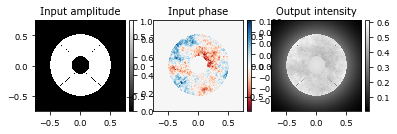

In [5]:
# Creating the aberrated wavefront
phase_aberrated = make_power_law_error(pupil_grid, 0.2, 1)
phase_aberrated -= np.mean(phase_aberrated[telescope_pupil >= 0.5])
wf = Wavefront(telescope_pupil * np.exp(1j * phase_aberrated))

# Applying the ZWFS
wf_out = ZWFS_ideal.forward(wf)

plot_ZWFS(wf, wf_out)

From the intensity of the outcoming wavefront, it is clear that the intensity is dependent on the input phase. To show a simple reconstruction, we use the reconstruction algorithm of N'Diaye et al. 2013 [1]:

\begin{equation}
\phi = −1 + \sqrt{2I_c},
\end{equation}

where $\phi$ is the phase and $I_c$ the measured intensity. 

[1] N'Diaye et al. "Calibration of quasi-static aberrations in exoplanet direct-imaging instruments with a Zernike phase-mask sensor", Astronomy & Astrophysics 555 (2013)

In [6]:
def plot_reconstruction_phase(phase_in, phase_out, telescope_pupil):
    '''Plot the incoming aberrated phase pattern and the reconstructed phase pattern
    
    Parameters
    ---------
    phase_in : Field
        The phase of the aberrated wavefront coming in
    phase_out : Field
        The phase of the aberrated wavefront as reconstructed by the ZWFS
    '''    
    
    # Calculating the difference of the reconstructed phase and input phase
    diff = phase_out - phase_in
    diff -= np.mean(diff[telescope_pupil >= 0.5])

    # Plotting the phase pattern and the PSF
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    im1 = imshow_field(phase_in, cmap='RdBu', vmin=-0.2, vmax=0.2, mask=telescope_pupil)
    ax1.set_title('Input phase')
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    ax2 = fig.add_subplot(132)
    im2 = imshow_field(phase_out, cmap='RdBu', vmin=-0.2, vmax=0.2, mask=telescope_pupil)
    ax2.set_title('Reconstructed phase')
    
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')
    
    ax3 = fig.add_subplot(133)
    im3 = imshow_field(diff, cmap='RdBu', vmin=-0.02, vmax=0.02, mask=telescope_pupil)
    ax3.set_title('Difference')
    
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')
    plt.show()

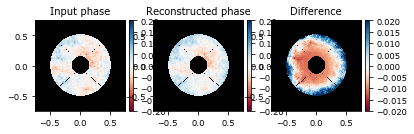

In [7]:
phase_est = -1 + np.sqrt(2 * wf_out.intensity)

plot_reconstruction_phase(phase_aberrated, phase_est, telescope_pupil)

Using the simplified formula, we reconstruct the phase to a large extend and most of the structure in the phase pattern is reconstructed. However, the difference is larger than 10% of the original phase amplitude, and is structured in the shape similar to defocus. 

In N'Diaye et al. 2013, they propose a more accurate reconstruction: 


\begin{equation}
\phi = \sqrt{-1 + 3 − 2b −(1−I_c)/b},
\end{equation}

The $b$ is a term correction factor that takes into account the apodization from the Zernike mask. It can be approximated using a Strehl estimate, $S$, the Zernike mask geometry, $M$, and the telescope pupil geometry $P_0$:

\begin{equation}
b \simeq S \widehat{M} \otimes P_0 = S b_0.
\end{equation}

Here $\widehat{M}$ is the Fourier transform of the Zernike mask geometry, $M$. 

In advance, the Strehl ratio is unkown. We set it to 1. Then we calculate the mask. 


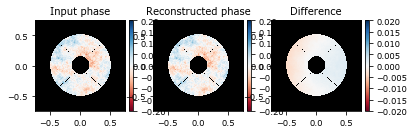

In [8]:
S = 1

# Creating the mask M
focal_grid = make_focal_grid(20, 2)

M = Apodizer(circular_aperture(1.06)(focal_grid))

# Calculating b0
prop = FraunhoferPropagator(pupil_grid, focal_grid)
b0 = prop.backward(M(prop.forward(Wavefront(telescope_pupil)))).electric_field.real

# Calculating b
b = np.sqrt(S) * b0

# Estimating the phase using the equations from above 
phase_est = -1 + np.sqrt(np.abs(3 - 2 * b - (1 - wf_out.intensity) / b))

plot_reconstruction_phase(phase_aberrated, phase_est, telescope_pupil)

It is clear that the ZWFS can accurately reconstruct the phase using the correction factor. 

However, one important limiting factor of the ZWFS reconstruction are amplitude errors, to which it is blind. This means that it reconstructs them as phase errors. To show this effect, we will propagate the phase aberration over a small distance using Fresnel propagation. 

In general, a ZWFS is least sensitive to tip-tilt modes and residual tip-tilt aberrations will dominate the reconstructed phase. In this notebook we will take the liberty to remove these tip-tilt modes. We also remove piston, as it is not important to reconstruct absolute phase. 

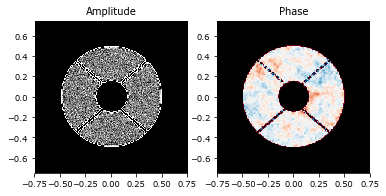

In [9]:
# Setting up the Fresnel propagator
prop_extra = FresnelPropagator(pupil_grid, distance=1e-4)

# Creating the power law error
phase_aberrated = make_power_law_error(pupil_grid, 0.3, 1)
phase_aberrated -= np.mean(phase_aberrated[telescope_pupil >= 0.5])

# Removing the piston and tip-tilt modes.
zbasis = make_zernike_basis(3, 1, pupil_grid)
for test in zbasis:
    test*= telescope_pupil
    phase_aberrated -= test * np.dot(phase_aberrated, test) / np.dot(test, test)

# Use super-Gaussian to avoid edge effects
p = telescope_pupil * np.exp(-(pupil_grid.as_('polar').r / 0.68)**20)
wf_new = prop_extra(Wavefront(p * np.exp(1j * phase_aberrated)))

# Updating reference phase and multiplying with the telescope pupil 
phase_aberrated = (wf_new.phase - np.pi) % (2 * np.pi) - np.pi
wf_new.electric_field[telescope_pupil < 0.5] = 0

# Plotting the aberration
plt.figure()
plt.subplot(1,2,1)
imshow_field((wf_new.amplitude * telescope_pupil) - 1, vmin=-0.02, vmax=0.02, cmap='gray')
plt.title('Amplitude')
plt.subplot(1,2,2)
imshow_field(wf_new.phase*telescope_pupil, vmin=-0.2, vmax=0.2, cmap='RdBu', mask=telescope_pupil)
plt.title('Phase')
plt.show()


The Fresnel propagation added mostly high-frequency ampltitude variations and changed the phase a bit. To see the effect of these aberrations on the ZWFS, we redo the reconstruction.

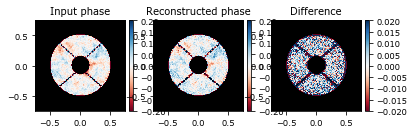

In [10]:
wf_out = ZWFS_ideal.forward(wf_new.copy())

S = 1

b = np.sqrt(S) * b0

phase_est = -1 + np.sqrt(np.abs(3 - 2 * b0 - (1 - wf_out.intensity) / b0))

plot_reconstruction_phase(phase_aberrated, phase_est, telescope_pupil)

As expected, the amplitude aberrations have been reconstructed as phase aberrations. The performance is worse and a lot of high-frequency noise has been added to the reconstructed phase. 

The rest of this notebook will introduce the vector-Zernike wavefront sensor, how the VZWFS output can be analysed and demonstrate the simultaneous phase and amplitude reconstruction. 

We start by creating the vZWFS optical element, similar to the ZWFS.

In [11]:
vZWFS_ideal = VectorZernikeWavefrontSensorOptics(pupil_grid, num_pix=128)

To demonstrate the reconstructed amplitude, we generate the same plot function for amplitude as has been created for the phase.  

In [12]:
def plot_reconstruction_amplitude(amplitude_in, amplitude_out, telescope_pupil):
    '''Plot the incoming aberrated amplitude pattern and the reconstructed amplitude pattern
    
    Parameters
    ---------
    amplitude_in : Field
        The phase of the aberrated wavefront coming in
    amplitude_out : Field
        The amplitude of the aberrated wavefront as reconstructed by the vZWFS
    '''    

    amplitude_in = amplitude_in - 1
    amplitude_out = amplitude_out - 1
    
    # Plotting the phase pattern and the PSF
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    im1 = imshow_field(amplitude_in, cmap='gray', vmin=-0.05, vmax=0.05, mask=telescope_pupil)
    ax1.set_title('Input amplitude')
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    ax2 = fig.add_subplot(132)
    im2 = imshow_field(amplitude_out, cmap='gray', vmin=-0.05, vmax=0.05, mask=telescope_pupil)
    ax2.set_title('Reconstructed amplitude')
    
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')
    
    ax3 = fig.add_subplot(133)
    im3 = imshow_field(amplitude_out - amplitude_in, cmap='gray', vmin=-0.01, vmax=0.01, mask=telescope_pupil)
    ax3.set_title('Difference')
    
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')
    plt.show()

Now comes the most important part. The vZWFS applies $+\frac{\pi}{2}$ and $-\frac{\pi}{2}$ to the two orthogonal circular polarization states respectivily. Therefore, we have to add a circular polarizing beam splitter that separates these two polarization states. 

Then we follow the equations in Doelman et al. 2019 [1] to reconstruct the phase. We use both pupil intensities and combine these to calculate the phase and amplitude (or rather the square root of the intensity) from one snap shot.

We start off by assuming a Strehl of 1. However, it is possible to update our estimate of b after calculating the phase and amplitude. We update the wavefront estimate that is used to calculate b and repeat the process. This allows for a slightly more accurate phase reconstruction. 


[1] Doelman, David S., et al. "Simultaneous phase and amplitude aberration sensing with a liquid-crystal vector-Zernike phase mask." Optics letters 44.1 (2019)

In [13]:
def reconstructor(wavefront):
    '''Plot the incoming aberrated phase pattern and the reconstructed phase pattern
    
    Parameters
    ---------
    phase_in : Field
        The phase of the aberrated wavefront coming in
    phase_out : Field
        The phase of the aberrated wavefront as reconstructed by the ZWFS
    '''
    # Separate circular polarization states
    CPBS = CircularPolarizingBeamSplitter()
    wf_ch1, wf_ch2 = CPBS.forward(wavefront.copy())
    I_L = wf_ch1.I 
    I_R = wf_ch2.I

    # Creating masks for reconstruction
    M = Apodizer(circular_aperture(1.06)(focal_grid))   
    b0 = np.abs(prop.backward(M(prop.forward(Wavefront(telescope_pupil)))).electric_field)
    S = 1
    b = np.sqrt(S) * b0

    # Calculating the phase and amplitude aberrations.
    for i in range(2):
        amp_est = np.nan_to_num(np.sqrt(I_L + I_R + np.sqrt(np.abs(4 * b**2 * (I_R + I_L) - (I_R - I_L)**2 - 4 * b**4))))
        phase_est = np.arcsin(I_L - I_R) / (2 * amp_est * b)
        
        #Updating b for improved estimate
        wf_est = Wavefront(amp_est * telescope_pupil * np.exp(1j * phase_est))
        b = prop.backward(M(prop.forward(wf_est))).electric_field.real
        
    return amp_est, phase_est
    

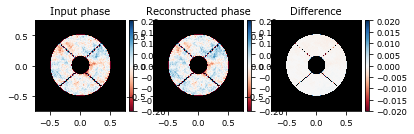

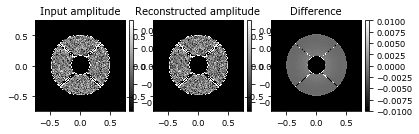

In [14]:
amp_est, phase_est = reconstructor(vZWFS_ideal(wf_new.copy()))

I_est = amp_est**2

plot_reconstruction_phase(wf_new.phase, phase_est, telescope_pupil)
plot_reconstruction_amplitude(wf_new.I, I_est, telescope_pupil)

Both the phase and amplitude are reconstructed without cross-talk of phase and amplitude. This is the great advantage of a vector-Zernike wavefront sensor. 